# Feature engineering with Pandas

## Импорты 

In [1]:
import yaml

with open('../config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
# from xgboost import XGBRegressor

### Общая информация

In [203]:
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [212]:
test_df = pd.read_csv(cfg['house_pricing']['test_dataset'])
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Не все столбцы здесь выведены. Их список мы можем получить, используя аттрибут `columns`:

In [72]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Почистим данные в нескольких столбцах, основываясь на data_description

In [7]:
train_df["Exterior2nd"] = train_df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
train_df["GarageYrBlt"] = train_df["GarageYrBlt"].where(train_df.GarageYrBlt <= 2010, train_df.YearBuilt)
    # Names beginning with numbers are awkward to work with
train_df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
        }, inplace=True,)

In [82]:
cat_df = train_df.select_dtypes(include=['object'])
cat_df

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [83]:
num_df = train_df.select_dtypes(exclude=['object'])
num_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


## Коррелирующие признаки

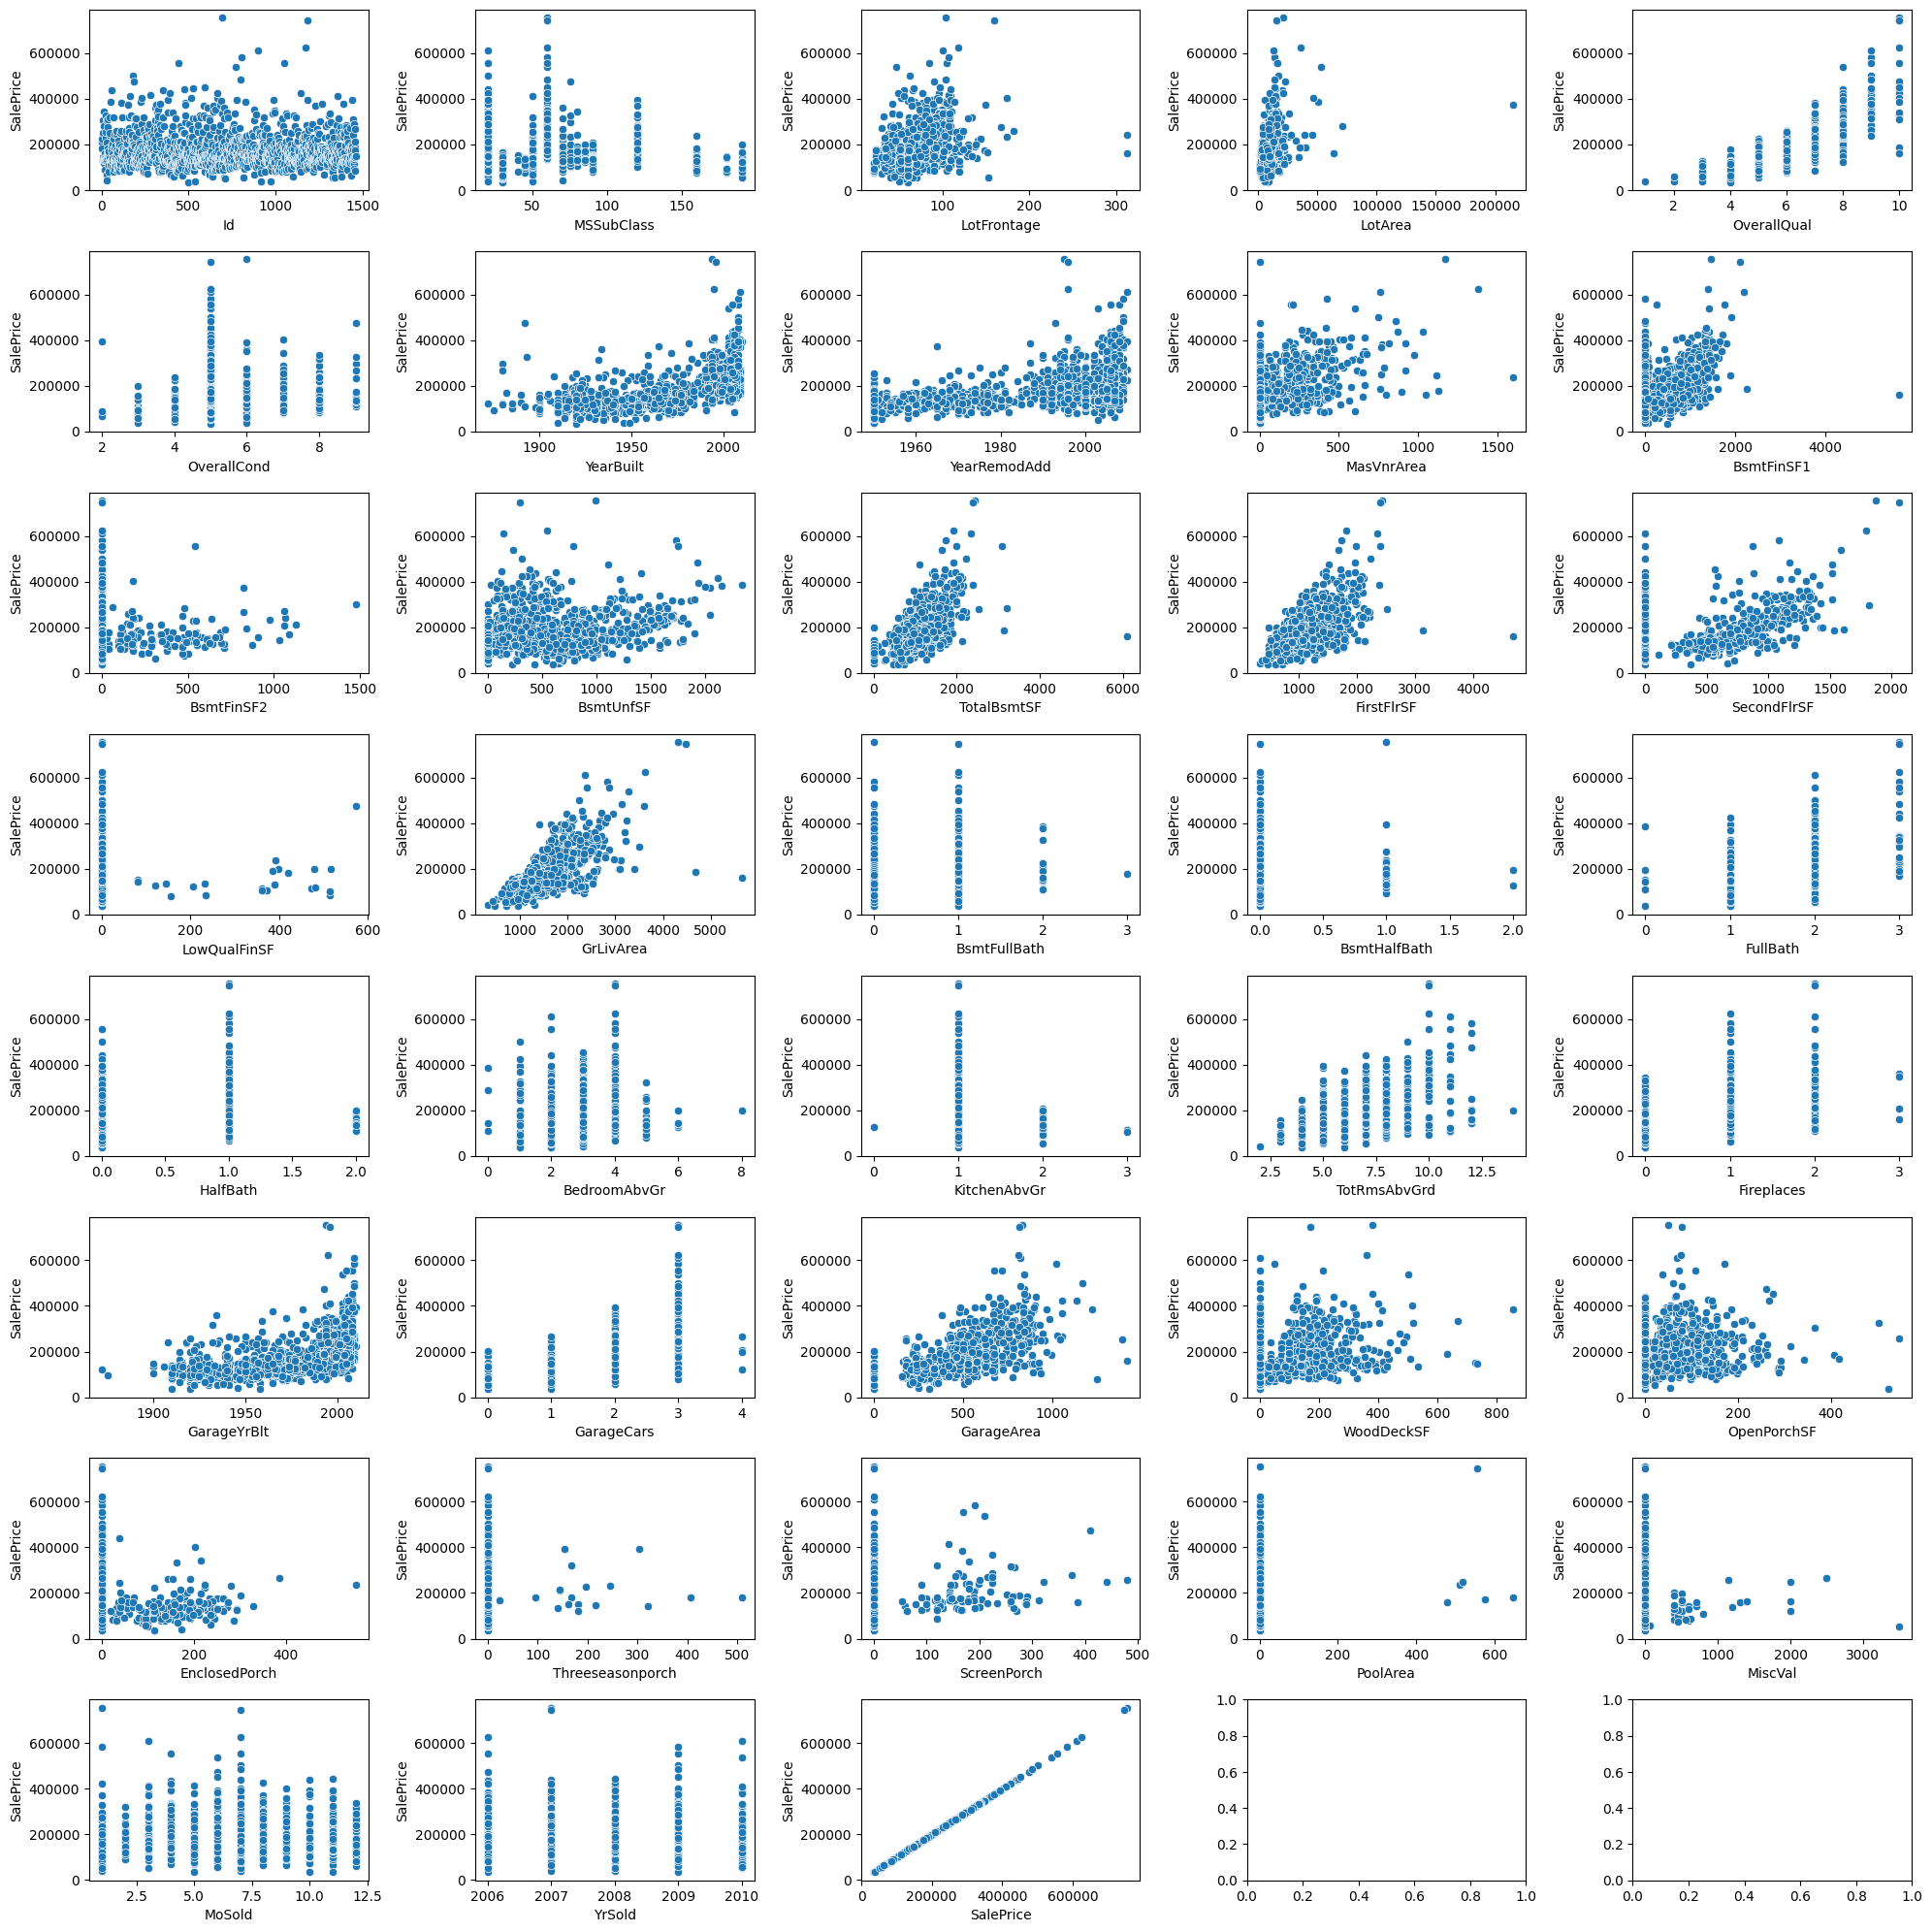

In [10]:
fig, axes = plt.subplots(8, 5, figsize=(20, 20))
axes_flattened = axes.reshape(-1)
for i in range(len(num_df.columns)):
    ax = axes_flattened[i]
    sns.scatterplot(
        x=num_df.iloc[:, i],
        y='SalePrice',
        data=num_df.dropna(),
        ax=ax,
    )
fig.tight_layout(pad=1.0)

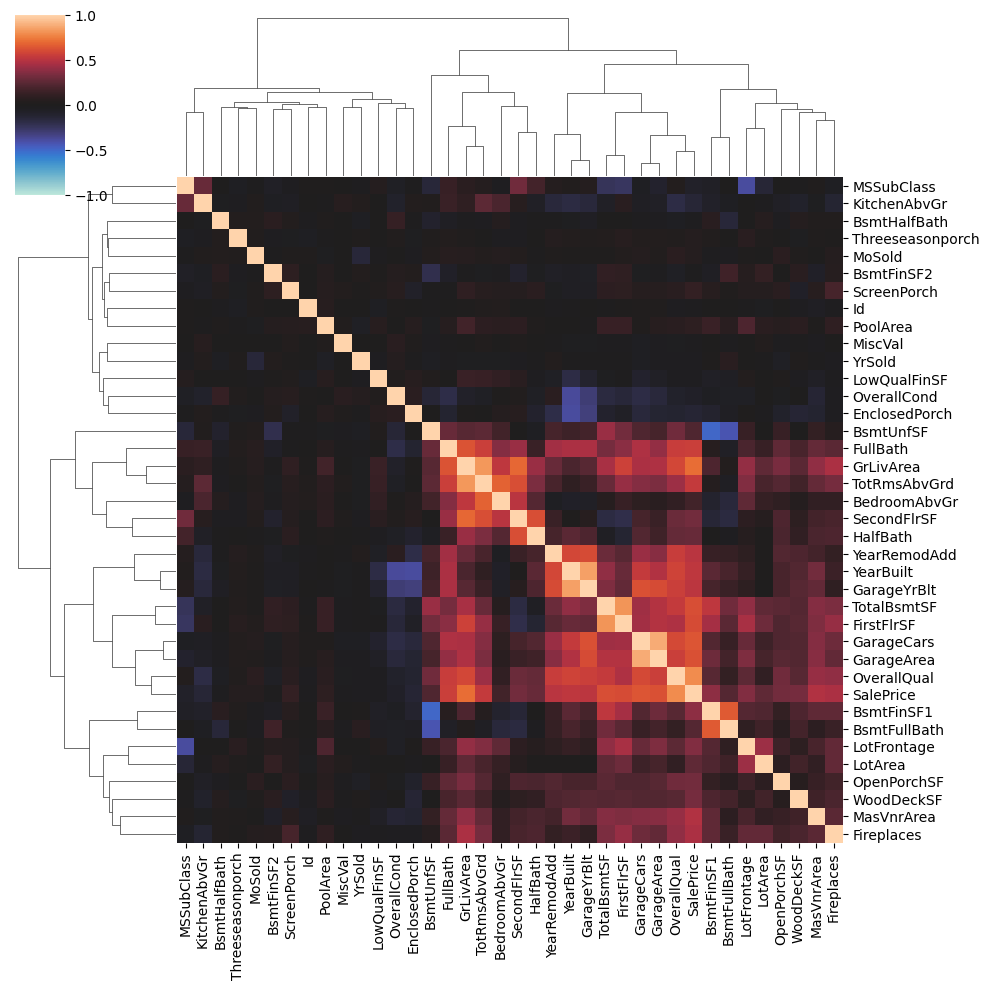

In [11]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(num_df, annot=None)

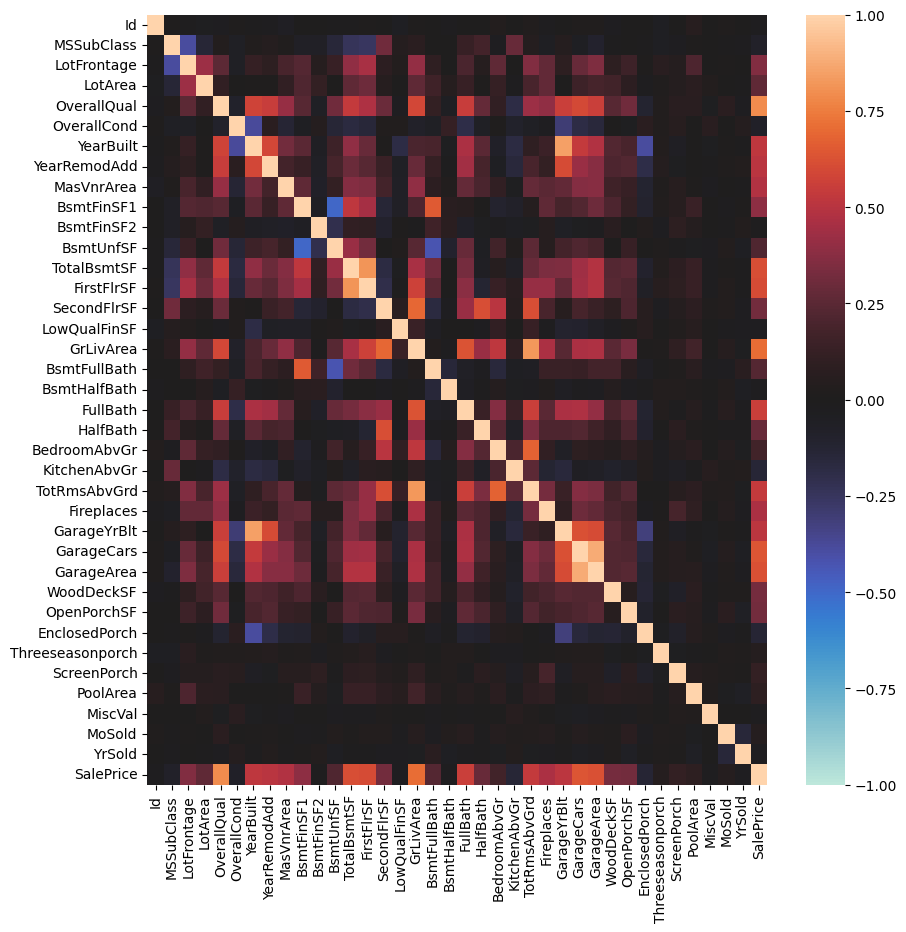

In [12]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        annot=annot,
        ax=ax,
        **kwargs,
    )


corrplot(num_df, annot=None)

Из этой матрицы можно увидеть, какие столбцы сильно коррелируют между собой, например:
1. GarageYrBlt и YearBuilt
2. TotRmsAbvGrd и GrLivArea
3. FirstFlrSF и TotalBsmtSF
4. GarageArea и GarageCars

**Задание**: Выведите 5 пар наиболее сильно коррелирующих признаков. Сколько пар признаков коррелирует больше, чем на 0.75?


In [13]:
correlation_matrix = num_df.corr()

corr_pairs = correlation_matrix.unstack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

corr_pairs = corr_pairs[corr_pairs['Feature1'] < corr_pairs['Feature2']]

sorted_corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False)

top_5_pairs = sorted_corr_pairs.head(10)
bottom_5_pairs = sorted_corr_pairs.tail(5)

high_corr_count = sorted_corr_pairs[sorted_corr_pairs['Correlation'] > 0.75].shape[0]

print("10 пар наиболее сильно коррелирующих признаков:")
print(top_5_pairs[['Feature1', 'Feature2', 'Correlation']])

print("\n5 пар с наименее коррелирующими признаками (отрицательные корреляции):")
print(bottom_5_pairs[['Feature1', 'Feature2', 'Correlation']])

print("\nКоличество пар, где корреляция больше 0.75:", high_corr_count)

10 пар наиболее сильно коррелирующих признаков:
          Feature1      Feature2  Correlation
1052    GarageArea    GarageCars     0.882475
956    GarageYrBlt     YearBuilt     0.845141
631      GrLivArea  TotRmsAbvGrd     0.825489
506     FirstFlrSF   TotalBsmtSF     0.819530
189    OverallQual     SalePrice     0.790982
645      GrLivArea     SalePrice     0.708624
622      GrLivArea   SecondFlrSF     0.687501
821   BedroomAbvGr  TotRmsAbvGrd     0.676620
359     BsmtFinSF1  BsmtFullBath     0.649212
1025    GarageCars     SalePrice     0.640409

5 пар с наименее коррелирующими признаками (отрицательные корреляции):
           Feature1    Feature2  Correlation
196     OverallCond   YearBuilt    -0.375983
77      LotFrontage  MSSubClass    -0.386347
1146  EnclosedPorch   YearBuilt    -0.387268
657    BsmtFullBath   BsmtUnfSF    -0.422900
353      BsmtFinSF1   BsmtUnfSF    -0.495251

Количество пар, где корреляция больше 0.75: 5


**Задание**: Постройте карту корреляций, но не используя clustermap. Используйте для этого heatmap. Ответьте на вопрос, те же пары признаков наиболее ярко подсвечены или разные? По какому из графиков вам удобнее делать выводы?

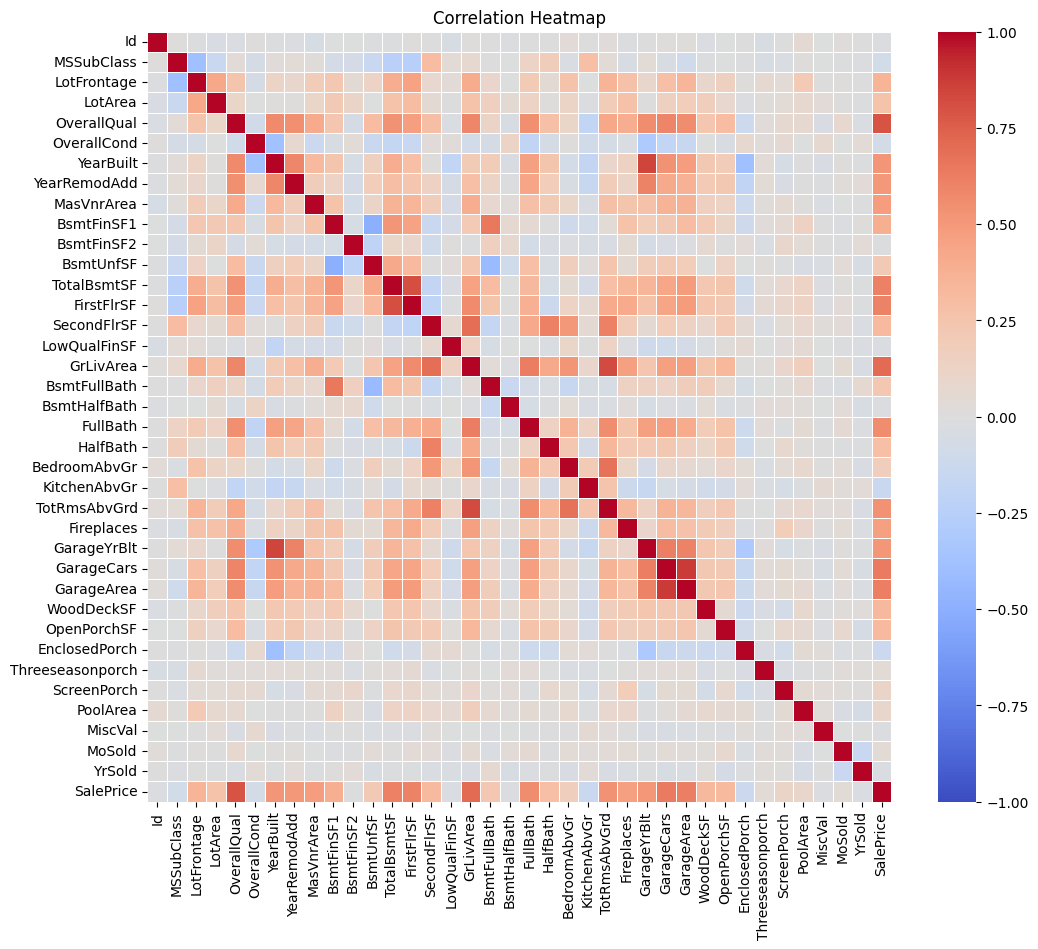

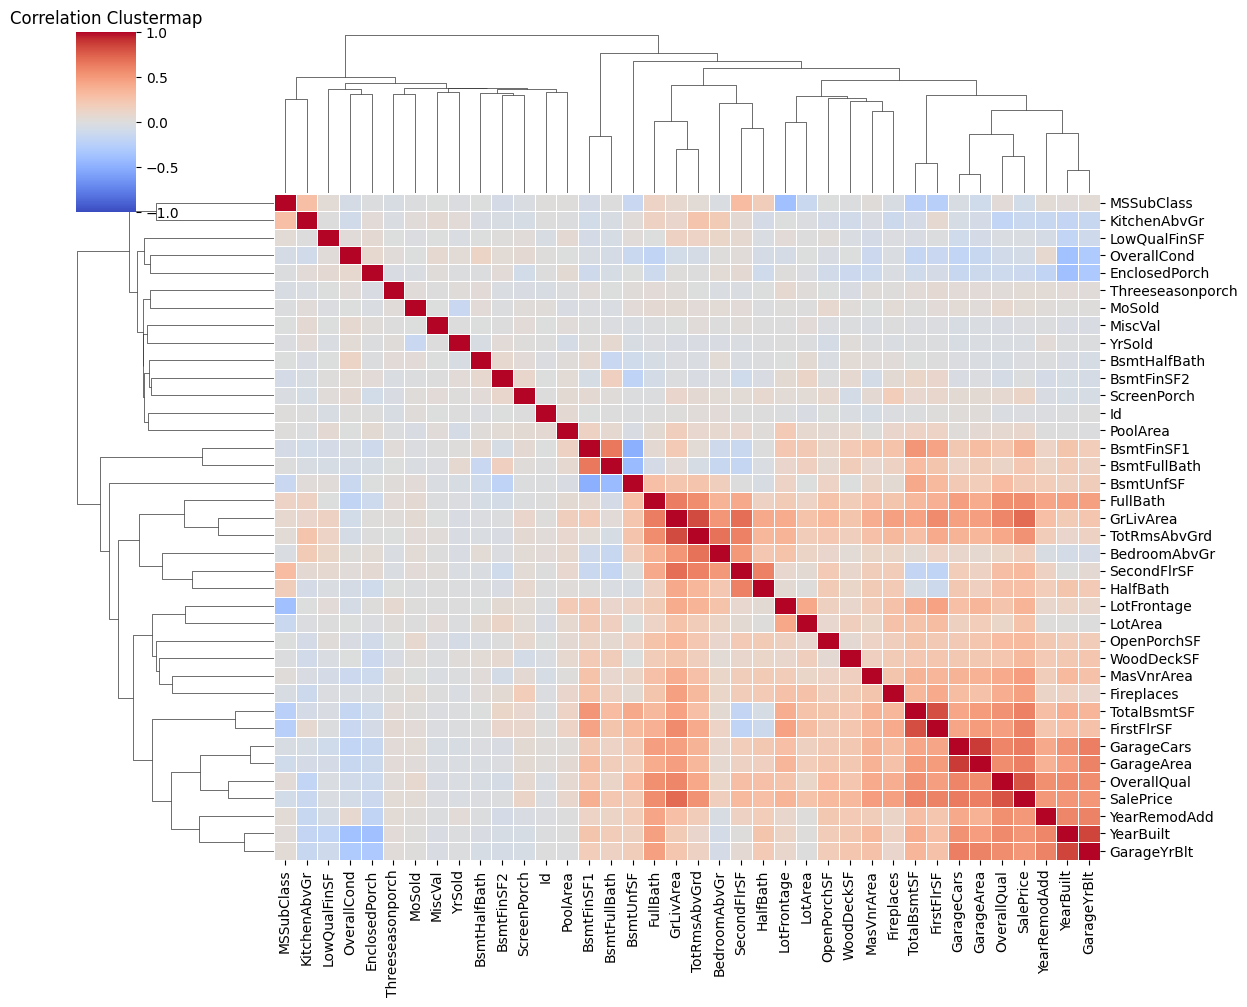

In [14]:
correlation_matrix = num_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap="coolwarm",
    vmin=-1.0, vmax=1.0,
    linewidths=0.5,
)
plt.title("Correlation Heatmap")
plt.show()

sns.clustermap(
    correlation_matrix,
    annot=False,
    cmap="coolwarm",
    figsize=(12, 10),
    vmin=-1.0, vmax=1.0,
    linewidths=0.5,
)
plt.title("Correlation Clustermap")
plt.show()

**Задание**: Выбросьте несколько лишних признаков из датасета.

In [15]:
missing_data = train_df.isnull().mean()
columns_to_drop = missing_data[missing_data > 0.5].index

print("Удаленные столбцы:", list(columns_to_drop))

#train_df.drop(columns_to_drop, axis=1, inplace=True)

Удаленные столбцы: ['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']


## Заполнение пустых значений

Может быть множество вариантов, при которых строка может содержать пустые значения. Например:
1. Дом с 2 спальнями не может включать ответ на вопрос, насколько велика третья спальня
2. Кто-то из опрошенных может не делиться своим доходом
3. ...
   
Библиотеки Python представляют недостающие числа как NaN-ми, что является сокращением от "not a number".

Соберем статистику, связанную с NaN-ми. Какие ячейки имеют недостающие значения (в процентах), можно определить с помощью команды:

In [16]:
nan_df = (train_df.isnull().mean() * 100).reset_index()
nan_df

,index,0
0,Id,0.000000
1,MSSubClass,0.000000
2,MSZoning,0.000000
3,LotFrontage,17.739726
4,LotArea,0.000000
...,...,...
76,MoSold,0.000000
77,YrSold,0.000000
78,SaleType,0.000000
79,SaleCondition,0.000000


Преобразуем этот датафрейм в более изящный вид:

In [17]:
nan_df.columns = ["column_name", "percentage"]
nan_df.sort_values("percentage", ascending=False, inplace=True)
nan_df.head(10)

,column_name,percentage
72,PoolQC,99.520548
74,MiscFeature,96.301370
6,Alley,93.767123
73,Fence,80.753425
25,MasVnrType,59.726027
57,FireplaceQu,47.260274
3,LotFrontage,17.739726
58,GarageType,5.547945
64,GarageCond,5.547945
63,GarageQual,5.547945


In [18]:
test_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Выведем квантили:

In [19]:
intro_srt = "Number of columns with more than"
for percent in (80, 50, 20, 5):
    print(f"{intro_srt} {percent}% NANs: {(nan_df.percentage > percent).sum()}")

Number of columns with more than 80% NANs: 4
Number of columns with more than 50% NANs: 5
Number of columns with more than 20% NANs: 6
Number of columns with more than 5% NANs: 11


Выведем столбцы с более чем 80% NaN-в

In [20]:
nan_columns = list(nan_df[nan_df.percentage > 80]['column_name'])
nan_columns

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

Большинство моделей не умеют работать с NaN-ми. Поэтому требуется избавиться от них.
Вообще есть три вида отсутствия значений: Полностью случайное, случайное и неслучайное. 
- Полностью случайное не связано ни с какими другими зависимостями в датасете. Удаление таких данных никак не повлияет на результаты.
- Случайное связано с наблюдаемыми переменными, но не с ненаблюдаемыми. Это самый широкий класс, и с ним борется большинство методов.
- Случайное, которое связано с ненаблюдаемыми переменными (например, старением оборудования).
В зависимости от того, с каким видом пропусков мы имеем дело, можно использовать разные методы.

### Выброс стоблцов с NaN-ми

In [21]:
# 1 вариант - если, например, нужно выбросить одинаковые 
# столбцы для обучающей и тестовой выборок
num_сols_with_missing = [col for col in num_df.columns 
                         if num_df[col].isnull().any()]
num_сols_with_missing

['LotFrontage', 'MasVnrArea']

In [22]:
print(len(num_df.columns))
num_df_dropped = num_df.drop(num_сols_with_missing, axis=1)
print(len(num_df_dropped.columns))

38
36


**2 опция:** выбросить столбцы, напрямую используя `dropna()`

In [23]:
print(len(num_df.columns))
num_df_dropped = num_df.dropna(axis=1)
print(len(num_df_dropped.columns))

38
36


Если эти столбцы содержат полезную информацию (в местах, которые не были пропущены), модель теряет доступ к этой информации при удалении столбца. Кроме того, если тестовые данные имеют отсутствующие значения в тех местах, где тренировочные не имели, это приведет к ошибке.
Однако оно может быть полезно, когда большинство значений в столбце отсутствуют. 

**Задание**: выбросьте столбцы, у которых отсутствует больше 75% значений.  Сделайе это и для тренировочных, и для тестовых данных

In [24]:
missing_data_train = train_df.isnull().mean()
missing_data_test = test_df.isnull().mean()

columns_to_drop = missing_data_train[missing_data_train > 0.75].index.union(
    missing_data_test[missing_data_test > 0.75].index
)

train_df_cleaned = train_df.drop(columns=columns_to_drop, axis=1)
test_df_cleaned = test_df.drop(columns=columns_to_drop, axis=1)

print("Удаленные столбцы:", list(columns_to_drop))


Удаленные столбцы: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


### Заполнение недостающих значений каким-то значением

Это значение будет не совсем правильным в большинстве случаев, но обычно оно дает более точные модели, чем полное удаление столбца.

**Числовые признаки**

Поведение по умолчанию заполняет столбец средним значением в заполненных ячейках. Существуют и более сложные стратегии.

In [25]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()

filled_cols = my_imputer.fit_transform(train_df[num_сols_with_missing])

In [26]:
filled_cols

array([[ 65., 196.],
       [ 80.,   0.],
       [ 68., 162.],
       ...,
       [ 66.,   0.],
       [ 68.,   0.],
       [ 75.,   0.]], shape=(1460, 2))

Альтернативно можно заполнить столбцы средним напрямую (или нулями, или чем угодно)

С точки зрения статистики такое заполнение оправдано, если все между признаками нет явной зависимости. В таком случае замена пропусков средними значениями не вносит смещения. Однако, часто условие независимости нарушается.

Взглянем на распределения средних значений по районам.

<Axes: xlabel='Neighborhood', ylabel='GarageArea_mean'>

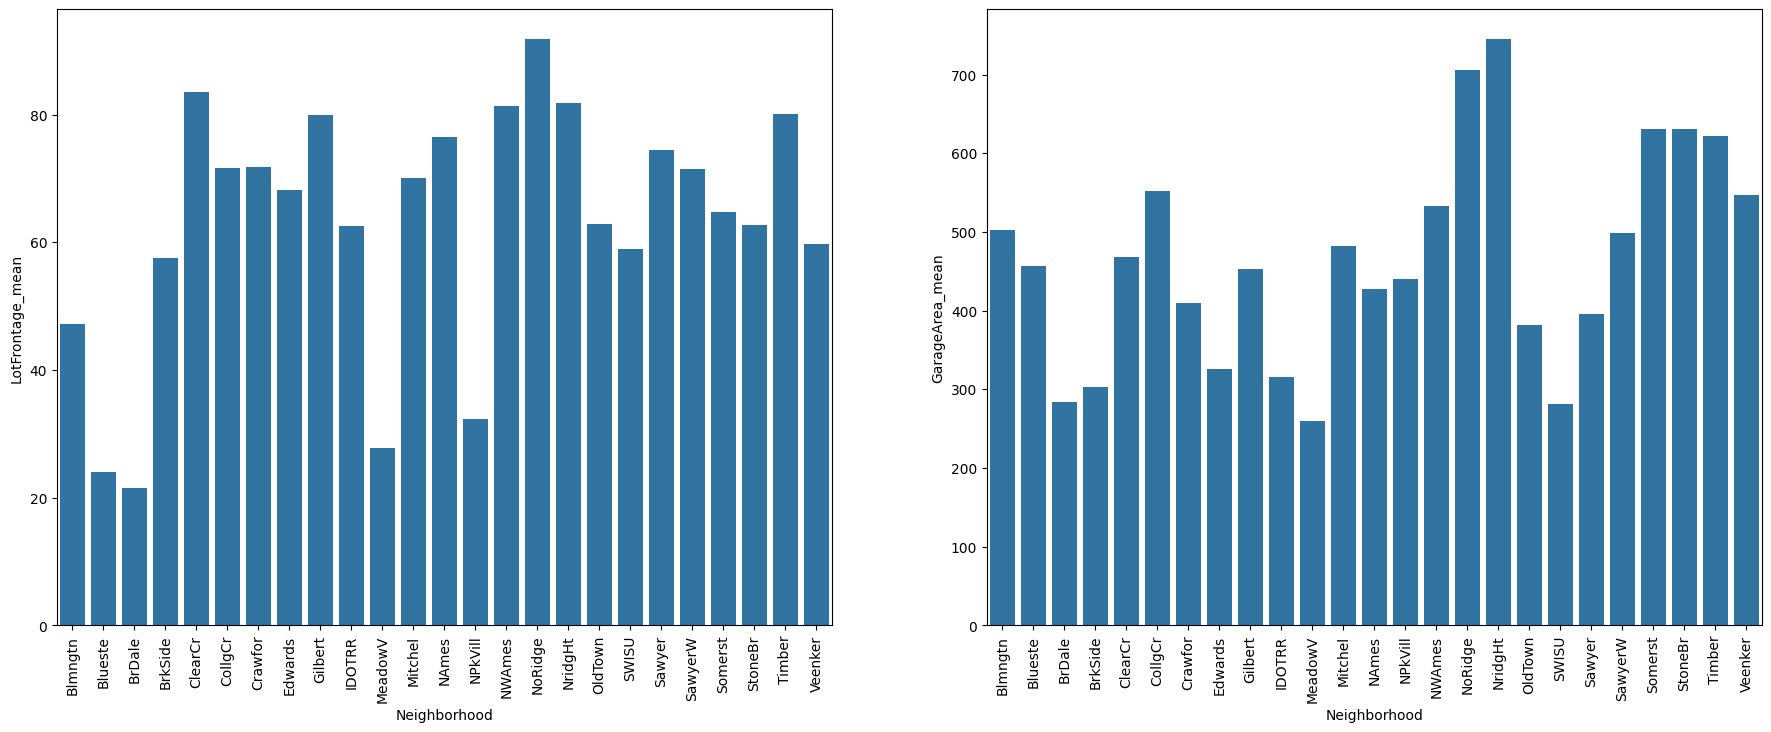

In [27]:
neigh_grouped = train_df.groupby('Neighborhood')
neigh_lot = (
    neigh_grouped['LotFrontage'].mean()
    .reset_index(name='LotFrontage_mean')
)
neigh_garage = (
    neigh_grouped['GarageArea'].mean()
    .reset_index(name='GarageArea_mean')
)

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

В данном примере свойства домов сильно зависят от того, в каком районе они расположены. Поэтому средние значения лучше считать по районам. Это будет простой вариант построения модели для заполнения значений. Вы также можете строить линейные модели или любые другие. 

In [28]:
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
train_df['GarageArea'] = train_df.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))

Заполним все оставшиеся числовые признаки средними (ранее мы не сохраняли результат в `train_df`)

In [29]:
train_df[num_сols_with_missing] = train_df[num_сols_with_missing].fillna(train_df[num_сols_with_missing].mean())

Те столбцы, которые содержали более 80% NANов, удалим совсем

In [30]:
train_df.drop(nan_columns, inplace=True, axis=1)

**Категориальные (номинальные) признаки**

Для заполнения категориапльных признаков естественно использовать значение по умолчанию "NA" или "missing". 


Понятие среднего здесь тяжело использовать, поэтому проще заполнить модой, то есть наиболее часто встречающимся значением. 

In [31]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', '

In [50]:
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
for col in cols:
    print(f"Mode of column {col} is {train_df[col].dropna().mode()[0]}")

def get_mode_or_nan(series):
    mode_values = series.dropna().mode()
    return mode_values[0] if not mode_values.empty else np.nan

train_df[cols] = train_df.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(get_mode_or_nan(x)))

Mode of column MasVnrType is BrkFace
Mode of column MSZoning is RL
Mode of column Exterior1st is VinylSd
Mode of column Exterior2nd is VinylSd
Mode of column SaleType is WD
Mode of column Electrical is SBrkr
Mode of column Functional is Typ


C:\Users\Faste\AppData\Local\Temp\ipykernel_13968\2223143621.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df[cols] = train_df.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(get_mode_or_nan(x)))


**Порядковые признаки**

Значение "NA" удобно ассоциировать с нулем. Но такая замена меняет число уровней у признака, что может быть нежелательно. Более того, часто неочевидно, какой уровень признака соответствует NA.

In [48]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']
train_df[cat] = train_df[cat].fillna("NA")

Одним из основных недостатков простого заполнения является то, что оно может привести к невозможным конфигурациям в данных. Представьте, что гараж отсутствует, но мы знаем число мест для машин. И хотя это неверно с точки зрения логики, это может быть все раыдно улучшением отсносительно ситуации, когда модель вообще не работала на прмиере с пропуском.

**Задание**: Используя simple imputer или заполнение модой на исходных тренировочных данных (вероятно, копии), создайте и найдите невозможную комбинацию (комбинации) в данных. Покажите пример(ы).

In [59]:
train_copy = train_df.copy()

num_imputer = SimpleImputer(strategy="mean")
train_copy[num_df.columns] = num_imputer.fit_transform(train_copy[num_df.columns])

cat_imputer = SimpleImputer(strategy="most_frequent")
train_copy[cat_df.columns] = cat_imputer.fit_transform(train_copy[cat_df.columns])

# Пример 1: Гаражного места нет, но указан тип гаража
impossible_garage = train_copy[(train_copy["GarageArea"] == 0) & (train_copy["GarageType"] != "None")]

# Пример 2: Нет внешних стен (Exterior1st и Exterior2nd = None)
impossible_exterior = train_copy[(train_copy["Exterior1st"].isna()) & (train_copy["Exterior2nd"].isna())]

# Пример 3: Невозможное сочетание MSZoning и HouseStyle
impossible_zoning = train_copy[(train_copy["MSZoning"] == "RL") & (train_copy["HouseStyle"] == "C (all)")]

print("Невозможные комбинации:")
print("\nГараж отсутствует, но указан его тип:")
print(impossible_garage[["GarageType", "GarageArea"]].head())

print("\nНет внешних стен:")
print(impossible_exterior[["Exterior1st", "Exterior2nd"]].head())

print("\nНеверное сочетание зонирования и типа дома:")
print(impossible_zoning[["MSZoning", "HouseStyle"]].head())



Невозможные комбинации:

Гараж отсутствует, но указан его тип:
   GarageType  GarageArea
39     Attchd         0.0
48     Attchd         0.0
78     Attchd         0.0
88     Attchd         0.0
89     Attchd         0.0

Нет внешних стен:
Empty DataFrame
Columns: [Exterior1st, Exterior2nd]
Index: []

Неверное сочетание зонирования и типа дома:
Empty DataFrame
Columns: [MSZoning, HouseStyle]
Index: []


Другой минус константного заполнения - уменьшение дисперсии в данных, изменение распределения. Это происходит, так как мы добавляем много примеров с нулевой дисперсией. В том числе и поэтому полезно смотреть на зависмимость признака от других переменных.

**Задание**: Возьмите любой числовой столбец с достаточно хорошим распределением (в идеале, чтобы у гистограммы было несколько "горбов". МОжете сгенерировать или взять из данных. Выбросьте из него 10, 20, 50 и 70% примеров. Покажите на графиках, как меняется гистограмма. 


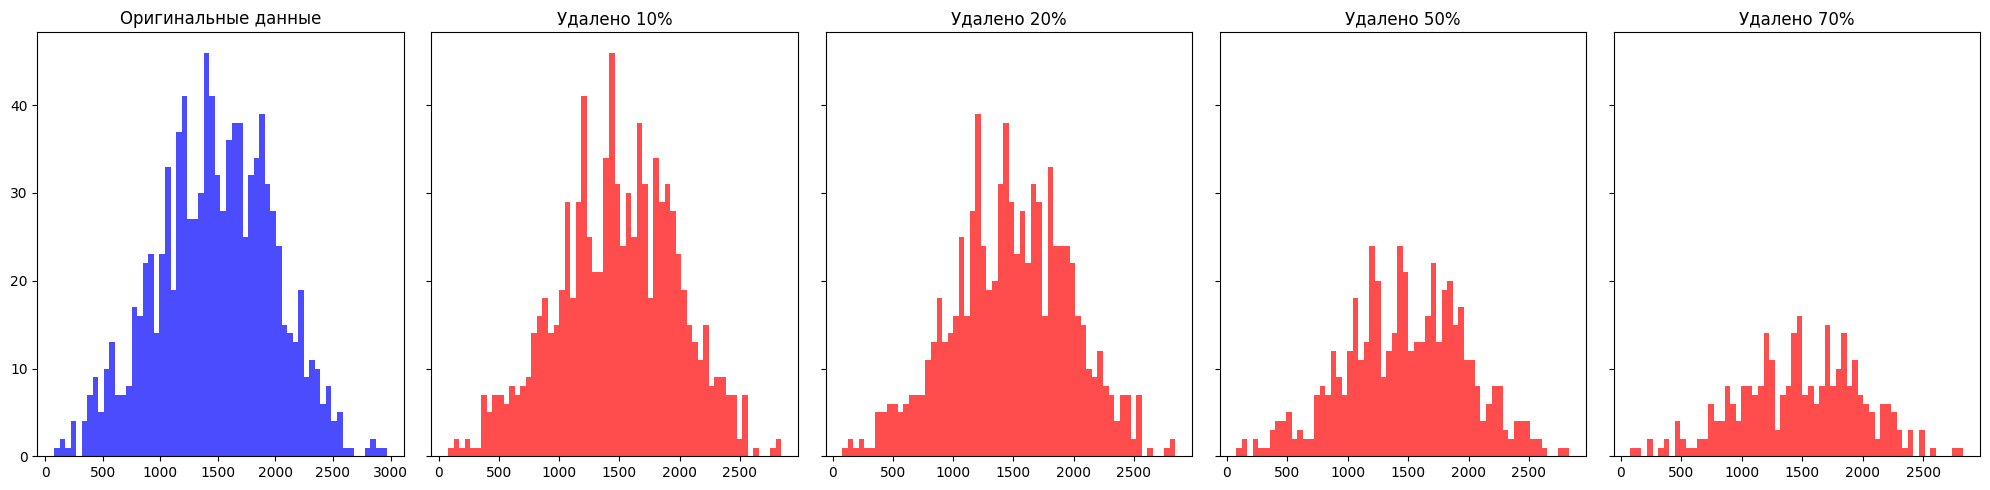

In [68]:
np.random.seed(69)
data = np.random.normal(loc=1500, scale=500, size=1000)
train_df = pd.DataFrame({"GrLivArea": data})

drop_ratios = [0.1, 0.2, 0.5, 0.7]

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
axes[0].hist(train_df["GrLivArea"], bins=60, color="blue", alpha=0.7)
axes[0].set_title("Оригинальные данные")

for i, ratio in enumerate(drop_ratios):
    dropped_df = train_df.sample(frac=(1 - ratio), random_state=42)  # Удаляем часть данных
    axes[i + 1].hist(dropped_df["GrLivArea"], bins=60, color="red", alpha=0.7)
    axes[i + 1].set_title(f"Удалено {int(ratio * 100)}%")

plt.tight_layout()
plt.show()


**Задание**: Попробуйте найти зависимость какой-нибудь категориальной переменной от других (от одного столбца). Заполните ее с учетом этой зависимости.

In [ ]:
zoning_counts = train_df.groupby("Neighborhood")["MSZoning"].agg(lambda x: x.mode()[0])
print(zoning_counts)

def fill_mszoning_by_neighborhood(row):
    if pd.isna(row["MSZoning"]):
        return zoning_counts[row["Neighborhood"]]
    return row["MSZoning"]

train_df["MSZoning"] = train_df.apply(fill_mszoning_by_neighborhood, axis=1)

print(train_df["MSZoning"].isna().sum())


Neighborhood
Blmngtn    RL
Blueste    RM
BrDale     RM
BrkSide    RM
ClearCr    RL
CollgCr    RL
Crawfor    RL
Edwards    RL
Gilbert    RL
IDOTRR     RM
MeadowV    RM
Mitchel    RL
NAmes      RL
NPkVill    RL
NWAmes     RL
NoRidge    RL
NridgHt    RL
OldTown    RM
SWISU      RL
Sawyer     RL
SawyerW    RL
Somerst    FV
StoneBr    RL
Timber     RL
Veenker    RL
Name: MSZoning, dtype: object
0


## Удаление признаков со слабой вариативностью

**Признаки с одним типичным значением**

Некоторые признаки в основном состоят из одного значения или нулей, что не особо полезно для нас. Поэтому мы устанавливаем пороговое значение, определяемое пользователем, на уровне 96%. Если столбец имеет более 96% от одного и того же значения, мы считаем признак бесполезными и удалим его.

In [95]:
def get_almost_constant_columns(df, dropna=True):
    cols = []
    for i in df:
        if dropna:
            counts = df[i].dropna().value_counts()
        else:
            counts = df[i].value_counts()
        most_popular_value_count = counts.iloc[0]
        if (most_popular_value_count / len(df)) * 100 > 96:
            cols.append(i)
    return cols

In [94]:
cat_df = train_df.select_dtypes(include=['object'])
overfit_cat = get_almost_constant_columns(cat_df)
train_df = train_df.drop(overfit_cat, axis=1)
overfit_cat

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [96]:
num_df = train_df.select_dtypes(exclude=['object'])
overfit_num = get_almost_constant_columns(num_df, dropna=True)
train_df = train_df.drop(overfit_num, axis=1)
overfit_num

['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal']

Иногда слабая вариативность все же не означает, что признак бесполезен. Это возможно для очень сильно несбалансированной переменной с малым количеством уровней. Более того, иногда такая несбалансированность возникает и в таргете!

**Признаки с маленькой дисперсией**

Другой способ - использовать метод VarianceThreshold от sklearn — это простой базовый подход к выбору признаков. Он удаляет все признаки, дисперсия которых не соответствует определенному порогу. По умолчанию он удаляет все элементы с нулевой дисперсией, т.е. те элементы, которые имеют одинаковое значение у всех семплов.

Стоит отметить, что дисперсия является абсолютной величиной, и выбор порога в этом случае является эмпирическим. При этом в общем случае малые значения дисперсии не говорят о бесполезности признака. Если признак задан на поле вещественных чисел, то его дискриминирующая способность не зависит от дисперсии, так как любой непрерывный интервал на вещественной оси содержит бесконечный набор значений. Однако, в случае дискретных значений (пример, целочисленных признаков) VarianceThreshold действительно становится полезным

In [100]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.1)
num_col = train_df.select_dtypes(exclude=['object'])

sel.fit(num_col)  # fit finds the features with low variance
sum(sel.get_support())

np.int64(36)

Метод `get_support()` возвратит булевскую маску для признаков, которые проходят указанный порог по дисперсии. Ее можно использовать для отбора этих признаков 

In [101]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Например, таким образом мы получаем список всех признаков, которые были отсеяны данным алгоритмом:

In [102]:
num_col.columns[~sel.get_support()]

Index(['BsmtHalfBath', 'KitchenAbvGr'], dtype='object')

## Удаление выбросов

Удаление выбросов предотвратит воздействие экстремальных значений на производительность наших моделей.

Из скаттерплотов выше мы можем увидеть, что следующие признаки имеют экстремальные выбросы:

* LotFrontage
* LotArea
* BsmtFinSF1
* TotalBsmtSF
* GrLivArea

Мы уберем выбросы на основе определенного порогового значения.
Эти значения мы получим из боксплотов ("ящик с усиками"):

![Boxplot](boxplot.png)

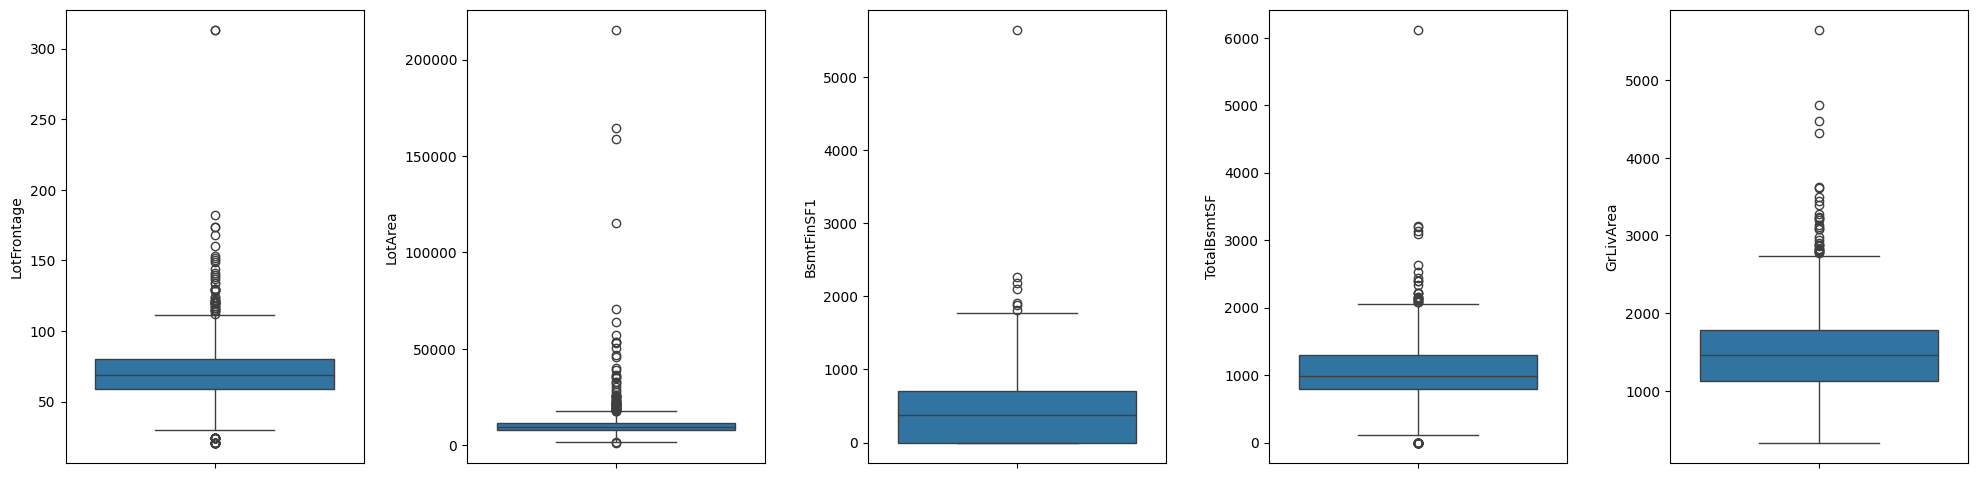

In [110]:
out_col = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axes, out_col):
    sns.boxplot(y=train_df[col], data=train_df, ax=ax)
fig.tight_layout(pad=1.5)

In [111]:
for col, upper_bound in (
    ('LotFrontage', 200),
    ('LotArea', 100000),
    ('BsmtFinSF1', 4000),
    ('TotalBsmtSF', 5000),
    ('GrLivArea', 4000),
):
    train_df = train_df.drop(train_df[train_df[col] > upper_bound].index)

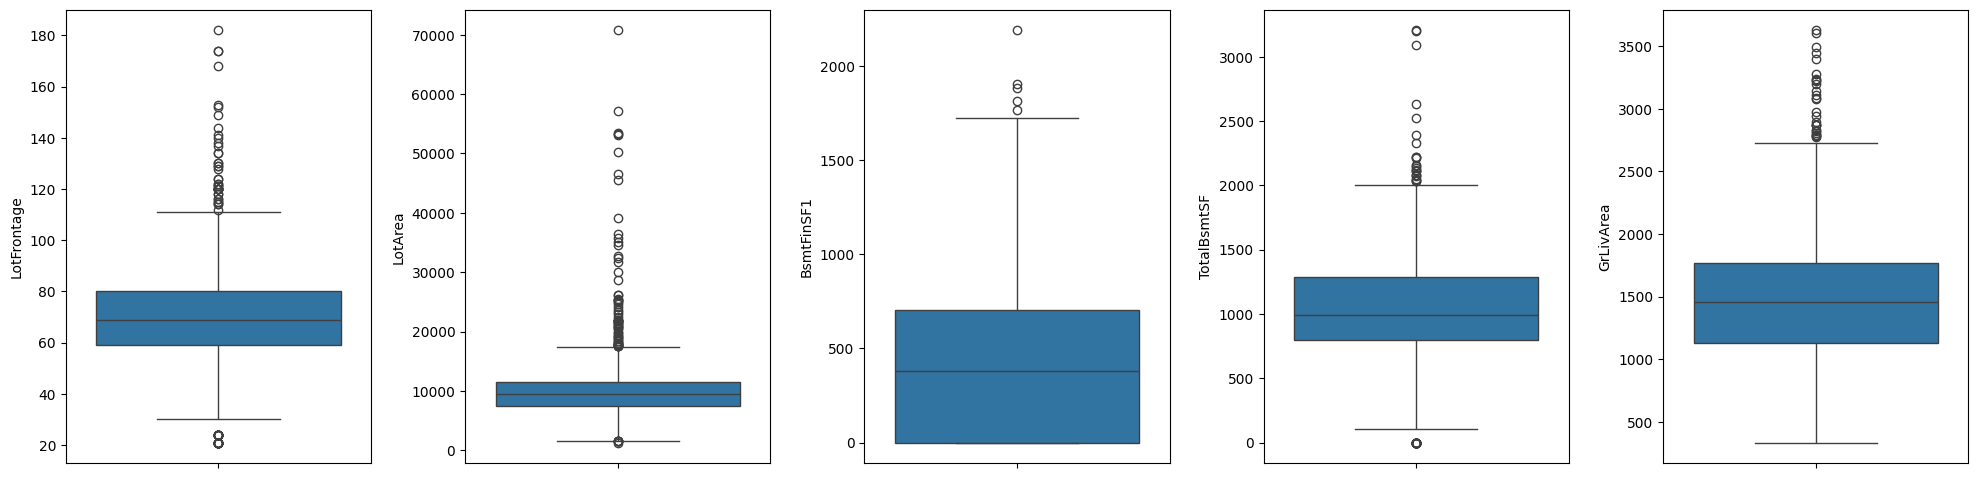

In [112]:
out_col = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axes, out_col):
    sns.boxplot(y=train_df[col], data=train_df, ax=ax)
fig.tight_layout(pad=1.5)

После удаления выбросов, сильно коррелированных признаков и условных отсутствующих значений мы можем приступить к добавлению дополнительной информации для обучения нашей модели. Это делается с помощью - Feature Engineering.

**Задание**: Создайте копию данных. Удалите из числовых столбцов выбросы (используя интерквартильный размах)

In [ ]:
train_cleaned = train_df.copy()
num_cols = train_cleaned.select_dtypes(include=['number']).columns

for col in num_cols:
    Q1 = train_cleaned[col].quantile(0.25)
    Q3 = train_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    train_cleaned = train_cleaned[(train_cleaned[col] >= lower_bound) & (train_cleaned[col] <= upper_bound)]

print(f"Размер train_df до удаления выбросов: {train_df.shape}")
print(f"Размер train_cleaned после удаления выбросов: {train_cleaned.shape}")


Размер train_df до удаления выбросов: (1460, 81)
Размер train_cleaned после удаления выбросов: (423, 81)


**Задание**: Определите, есть ли выбросы в LotArea после группировки по районам. Есть ли районы, в которых выбросы сильнее, чем в остальных? Есть ли связь признака "наличие выброса" c качеством дома?

Neighborhood
CollgCr    16
Edwards    14
NAmes      14
NWAmes      9
Gilbert     7
Mitchel     6
Timber      5
BrkSide     4
Sawyer      4
NoRidge     4
Name: LotArea_outlier, dtype: int64


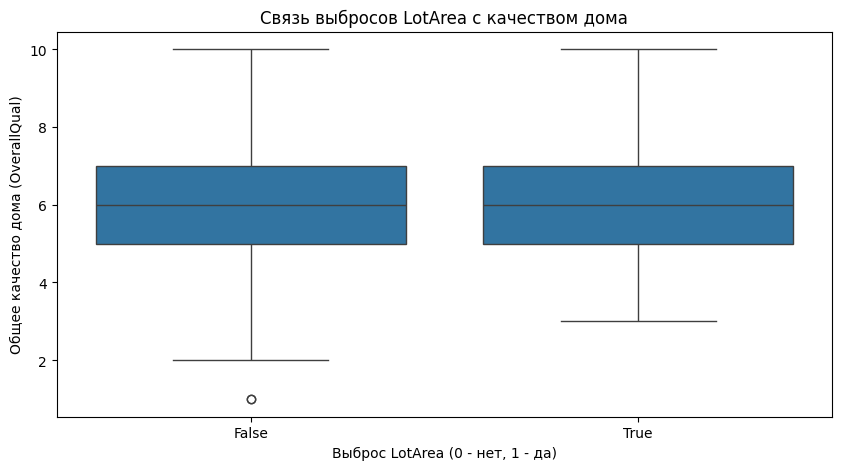

In [125]:
grouped = train_df.groupby("Neighborhood")["LotArea"]

Q1 = grouped.transform(lambda x: x.quantile(0.25))
Q3 = grouped.transform(lambda x: x.quantile(0.75))
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_df["LotArea_outlier"] = (train_df["LotArea"] < lower_bound) | (train_df["LotArea"] > upper_bound)

outlier_counts = train_df.groupby("Neighborhood")["LotArea_outlier"].sum().sort_values(ascending=False)
print(outlier_counts.head(10))

plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df["LotArea_outlier"], y=train_df["OverallQual"])
plt.xlabel("Выброс LotArea (0 - нет, 1 - да)")
plt.ylabel("Общее качество дома (OverallQual)")
plt.title("Связь выбросов LotArea с качеством дома")
plt.show()


## Feature Engineering

Feature Engineering - это техника, с помощью которой мы создаем новые признаки, которые потенциально могут помочь в прогнозировании нашей целевой переменной, которая в данном случае является SalePrice. 

MSSubClass - это столбец с числовым признаком, который на самом деле можно представить как категориальный

In [126]:
train_df['MSSubClass'].value_counts()

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64

In [127]:
train_df['MSSubClass'] = train_df['MSSubClass'].apply(str)

In [128]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [129]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    train_df[col] = train_df[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    train_df[col] = train_df[col].map(fintype_map)

train_df['BsmtExposure'] = train_df['BsmtExposure'].map(expose_map)

Основываясь на текущих признаках, мы можем добавить первый дополнительный признак, который будет называться TotalLot и который суммирует LotFrontage и LotArea для определения общей площади земли, доступной в виде лота. Мы также можем рассчитать общее количество площади поверхности дома, TotalSF, сложив площадь от 1-го этажа и 2-го этажа. TotalBath также может быть использован, чтобы сказать нам в общей сложности, сколько ванных комнат есть в доме. Мы также можем добавить все различные типы крыльц вокруг дома и обобщить в общей площади крыльца, TotalPorch.

* TotalLot = LotFrontage + LotArea
* TotalSF = TotalBsmtSF + 2ndFlrSF
* TotalBath = FullBath + HalfBath
* TotalPorch = OpenPorchSF + EnclosedPorch + ScreenPorch
* TotalBsmtFin = BsmtFinSF1 + BsmtFinSF2

In [133]:
train_df['TotalLot'] = train_df['LotFrontage'] + train_df['LotArea']
train_df['TotalBsmtFin'] = train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['2ndFlrSF']
train_df['TotalBath'] = train_df['FullBath'] + train_df['HalfBath']
train_df['TotalPorch'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['ScreenPorch']

Иногда очень важно применить к признаку какое-то выпуклое преобразование. Например, логарифм, корень или наоборот возведение в степень.

In [134]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [135]:
train_df["LivLotRatio"] = train_df["GrLivArea"] / train_df["LotArea"]

Мы также включаем создание бинарных столбцов для некоторых признаков, которые могут указывать на наличие(1) / отсутствие(0) некоторых признаков дома

In [137]:
cols = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

for col in cols:
    col_name = col+'_bin'
    train_df[col_name] = train_df[col].apply(lambda train_df: 1 if train_df > 0 else 0)

Наконец, поскольку нам нужны данные, которые носят численный характер, мы преобразуем оставшиеся категориальные столбцы с помощью one-hot-encoding с помощью метода get_dummies() в числовые столбцы, которые подходят для подачи в наш алгоритм машинного обучения.

In [138]:
train_df = pd.get_dummies(train_df)

In [139]:
len(train_df.columns)

301

In [140]:
train_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,False,False,False,True,False,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,False,False,False,True,False,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,False,False,False,True,False,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,False,False,False,True,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,False,False,False,True,False,False,False,False,True,False


## Кластеринг

Для создания новых признаков можно использовать обучение без учителя, например, кластеризацию с помощью k средних. Можно использовать как категорию (столбец с 0, 1, 2,...) метки кластеров или расстояние наблюдений до каждого кластера. Эти особенности иногда могут быть эффективными при распутывании сложных пространственных отношений.

In [152]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "2ndFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [153]:
cluster_df = cluster_labels(train_df, features=cluster_features)


In [158]:
cluster_df.head(1500)

,Cluster
0,4
1,6
2,1
3,4
4,8
...,...
1455,4
1456,2
1457,8
1458,19


In [159]:
train_df['cluster_num'] = cluster_df["Cluster"]

## Скейлинг

Есть две основные причины, зачем нам скейлинг:
1) Многие модели учитывают масштабы для построения прогнозов
2) Многие алгоритмы сходятся быстрее для шкалированных данных.
   
Часто используются логарифмирование для данных с сильно несимметричным распределением. Логарифмирование позволяет также решить проблему нелинейности в масштабе. Основная идея в переводе мультипликативной зависимости в аддитивную.
Для последнего рассмотрим следующий пример: Для концертов с различным масштабом увеличение аудитории на константу имеет разную значимость. Рассмотрим, что происходит каждый раз, когда размер аудитории увеличивается на 50%. Для начального размера аудитории 100 происходит следующее:
$$ \log_{10}(150) = \log_{10}(100 \cdot 1.5) = \log_{10}(100) + \log_{10}(1.5) \approx 2 + 0.176 $$
Для аудитории в 1000:
$$ \log_{10}(15,000) = \log_{10}(10,000 \cdot 1.5) = \log_{10}(10,000) + \log_{10}(1.5) \approx 4 + 0.176 $$
Так мы можем уменьтшить сатурацию важности признака в зависисмости от масштаба. Важно понимать, что мы не пытаемся нормализовать переменную, а именно решить проблему скошенности.

**Задание**: Найдите такой признак в наших данных и прологарифмируйте.

Что делать, если переменная может быть отрицательной? Для этого можно использовать
$$ y = log_{base}(x + offset) $$ 
offset позволяет сдвинуть значения в нужную сторону, и лучше он должен быть меньше, чем минимальное возможное. (Если, конечно, оно известно). 

Перекошенные признаки:
MSSubClass: skewness = 1.41
LotFrontage: skewness = 2.16
LotArea: skewness = 12.20
MasVnrArea: skewness = 2.67
BsmtFinSF1: skewness = 1.68
BsmtFinSF2: skewness = 4.25
TotalBsmtSF: skewness = 1.52
1stFlrSF: skewness = 1.38
LowQualFinSF: skewness = 9.00
GrLivArea: skewness = 1.37
BsmtHalfBath: skewness = 4.10
KitchenAbvGr: skewness = 4.48
WoodDeckSF: skewness = 1.54
OpenPorchSF: skewness = 2.36
EnclosedPorch: skewness = 3.09
3SsnPorch: skewness = 10.29
ScreenPorch: skewness = 4.12
PoolArea: skewness = 14.81
MiscVal: skewness = 24.45
SalePrice: skewness = 1.88
MiscVal_log: skewness = 5.17


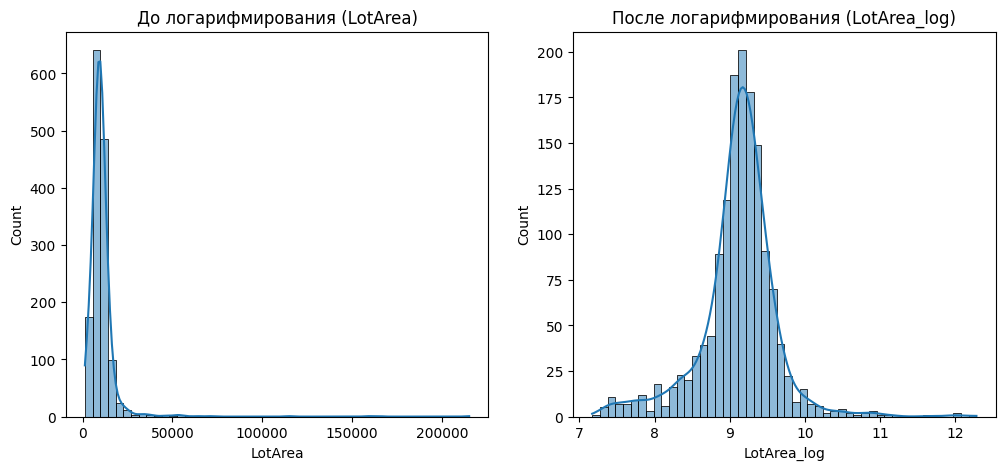

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

num_cols = train_df.select_dtypes(exclude=['object']).columns
skewness = train_df[num_cols].apply(lambda x: skew(x.dropna()))

skewed_features = skewness[abs(skewness) > 1].index

print("Перекошенные признаки:")
for col in skewed_features:
    print(f"{col}: skewness = {skewness[col]:.2f}")

feature = "LotArea"

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train_df[feature], bins=50, kde=True, ax=ax[0])
ax[0].set_title(f"До логарифмирования ({feature})")

train_df[feature + "_log"] = np.log1p(train_df[feature])

sns.histplot(train_df[feature + "_log"], bins=50, kde=True, ax=ax[1])
ax[1].set_title(f"После логарифмирования ({feature}_log)")

plt.show()


Это не универсальное решение. Хотя оно может улучшать распределения с перекосом вправо (где большинство точек данных имеют более низкие значения), он оказывает противоположный эффект на распределение, которое не искажено или смещено влево.

Есть ли альтернативы? Итак, нам нужен метод, который преобразует шкалу в неперекошенную, а также работает с отрицательными данными. 

Квадратный корень может быть тем, что мы ищем. Сам по себе он принимает на вход положительное число и возвращает число, которое при умножении на себя равно входному значению. Это дает желаемый эффект сжатия: большие значения сжимаются сильнее, чем меньшие. Кроме того, поскольку его областью определения являются положительные числа (0 — это особый случай, поскольку он отображается сам в себя), мы можем отразить его, чтобы работать с отрицательными числами так же, как он работал с положительными числами. Это приводит к следующему преобразованию:
$$ y = \text{sign}(x)\sqrt{\left| x \right|} $$

У него нет такой возможности сжимать большие значения, как у логарифмов, но зато оно будет легко работать с отрицательными значениями и позволит  уловить квадратичные эффекты. Однако, хотя оно сохраняет порядок числовых значений, но не дает нам хорошего способа интерпретировать изменения (и может исказить неискаженные распределения).

### Скейлинг с обучением
RobustScaler - это метод преобразования, который удаляет медиану и масштабирует данные в соответствии с диапазоном квантиля (по умолчанию IQR: межквартильный диапазон). IQR - это диапазон между 1-м квартилем (25-й квантилем) и 3 Квартиль (75-й квантиль). Он также устойчив к пропускам, что делает его идеальным для данных, где слишком много пропусков, что резко сокращает количество обучающих данных.

Запуская скейлер как на тренировочном, так и на тестовом наборах, мы подвергаем себя проблеме утечки данных. Утечка данных - это проблема, когда для создания модели используется информация извне набора для обучения. Если мы подгоняем скейлер как на тренировочные, так и на тестовые данные, наши характеристики тренировочных данных будут содержать распределение нашего тестового набора. Таким образом, мы неявно передаем информацию о наших тестовых данных в окончательные тренировочные данные для обучения, что не даст нам возможности по-настоящему протестировать нашу модель на данных, которые она никогда не видела.

*Извлеченные уроки:* Установка скейлера только на обучающие данные, а затем преобразование данных как обучающей, так и тестовой выборок

In [219]:
from sklearn.preprocessing import RobustScaler

if "Id" in train_df.columns:
    train_df = train_df.drop("Id", axis=1)

cols = train_df.select_dtypes(include=[np.number]).columns.drop("SalePrice", errors="ignore")

scaler = RobustScaler().fit(train_df[cols])
train_df[cols] = scaler.transform(train_df[cols])

if "Id" in test_df.columns:
    test_ids = test_df["Id"]
    test_df = test_df.drop("Id", axis=1)

test_df = pd.get_dummies(test_df)

missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0

test_df = test_df[train_df.columns.drop("SalePrice", errors="ignore")]

test_df[cols] = scaler.transform(test_df[cols])


Таким образом, мы сильно преобразовали наш обучающий набор. Кроме перчисленного, полезно использовать PCA, выбор признаков на основе информации и други методы. Как вы, наверное, заметили, все преобразования были сделаны только для тренировочного набора, но то же самое необходимо сделать и для тестового.

Чтобы предотвратить утечку данных, все преобразования по среднему и тп нужно сделать независимо, а если мы, например, кодировали или удаляли столбцы, нужно сделать такое же преобразование, используя старые правила. 

После того, как это было сделано, можно передавать данные в модель.

**Задание**: Используя признаки, построенные для обучающего набора, дополните тестовый. Сохраните резщультирующие наборы на будущее.